Policy Function Converged

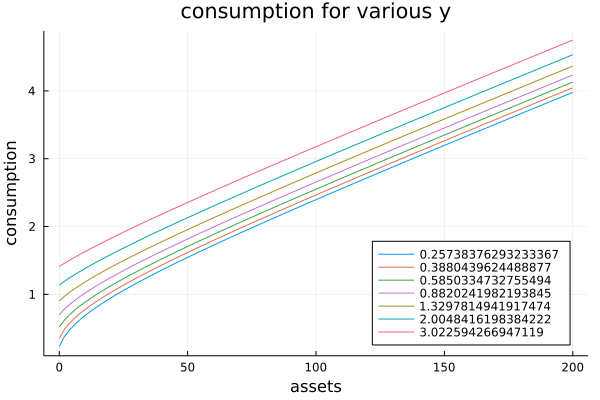

In [1]:
# RANC: Income Fluctuation Problem with Occasionally Binding Constraints
# With Time Iteration and Endogenous Grid Method
# Problem: V(y,a) = max u(c)+βE[V(y',a')|y]
# s.t. c + a' = (1+r)a + y, c>=0, a'>= lb
# y'\y ~ N
# Euler: u'(c(y, a)) = β(1+r)E[u'(c(y',a'))]     (> if a'= 0)
# EGM: Guess c(a',y') and for each y', a' obtain Optimal c (and a) via Euler Equation
# Time Iteration: Repeat EGM until c converges to guess. 

using NBInclude
@nbinclude("1_shock_discretization.ipynb")
@nbinclude("2_income_fluctuation.ipynb")

Policy Function Converged

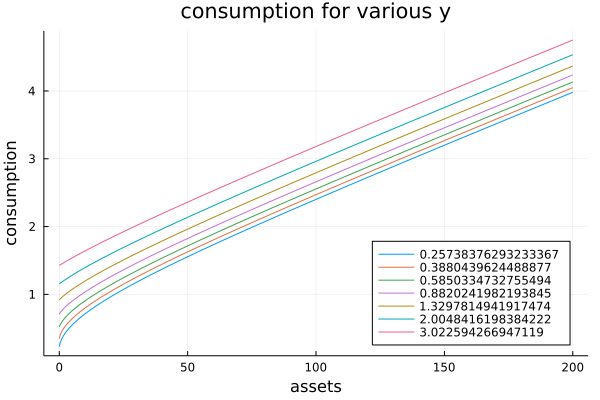

In [2]:
using Distributions, BenchmarkTools, Parameters, Interpolations, LinearAlgebra, Plots

# Parameters
ub = 200 # upper bound for assets
lb = 0 # lower bound for assets (can be negative)
β = 0.98 # patience
α = 0.11 # share of capital in income
δ = 0.025 # depreciation
γ = 2 # elasticity of substitution

# Utility Function Tools
u(c, γ) = c.^(1-γ)/(1-γ) # period utility
up(c, γ) = c.^-γ # marginal utility
invup(up, γ) = up.^(-1/γ) # inverse of marginal utility

# Income Process
ρ = 0.966
N_Y = 7
σ = 0.13
σ = σ/sqrt(1-ρ^2)
μ = 0
#P, Y = tauchen(μ,σ,ρ,N_Y) # Shock Space and Transition Matrix
P, Y = rowenhorst(μ,σ,ρ,N_Y) # Shock Space and Transition Matrix

# Asset and Income Grids
N_A = 500

# Plotting c(y,a) for different y
Agrid, Ygrid = getGrids(ub, lb, N_A, N_Y, Y)
c, ap = TimeIteration(0.01)
plot(Agrid[:,1], c, label = Y', xlabel = "assets", ylabel = "consumption", title = "consumption for various y", legend = :bottomright)

In [3]:
function get_kernel(ap)
    
"""
    get transition kernel for asset-income distribution using Young's method
    
    #### Fields
    
    - 'hh': household tuple
    - 'policyfun': savings function, array na x ny
    
    #### Returns
    
    - 'kernel': na*ny x na*ny array row-stochastic transition kernel
                first na rows correspond to income state 1, second na rows to income state 2, etc...
"""

    # construct transition matrix without labour stochasticity
    Q = zeros(N_A, N_A, N_Y)

    # find which element to interpolate to
    findnearest(A,t) = findmin(abs.(A.-t))[2]

    # construct matrices to get neighboring indices
    next = similar(Agrid)
    previous = similar(Agrid)

    for j = 1:N_Y
        for k = 1:N_A
            ind = findnearest(Agrid[:,j],ap[k,j])
                if ap[k,j] - Agrid[ind,j] > 0
                    previous[k,j] = Agrid[ind,j]
                    if ind == N_A
                        next[k,j] = Agrid[ind,j]
                    else         
                    next[k,j] = Agrid[ind+1,j]
                    end
                elseif ap[k,j] == Agrid[ind,j]
                    previous[k,j] = ap[k,j] 
                    next[k,j] = ap[k,]
                else
                    next[k,j] = Agrid[ind,j]
                    if ind == 1
                        previous[k,j] = Agrid[ind,j]
                    else
                        previous[k,j] = Agrid[ind-1,j]
                    end
                end  
        end
    end

    # construct transition matrix for assets.
    # Q[i,j,k] is the probability of going to agrid[i] when current assets are agrid[j] and income is ygrid[k]
    for k = 1:N_A
        for j = 1:N_Y
            if next[k,j] == previous[k,j]
                Q[Agrid[:,1].==previous[k,j],k,j] .= 1
            else
                Q[Agrid[:,1].==previous[k,j],k,j] .= (next[k,j]-ap[k,j])./(next[k,j]-ap[k,j])
                Q[Agrid[:,1].==next[k,j],k,j] .= 1 - (next[k,j]-ap[k,j])./(next[k,j]-ap[k,j])

            end
        end
    end

    # construct transition kernel by taking the kronecker product of assets and transition_matrix for income
    kernel = zeros(N_A*N_Y,N_A*N_Y)

    for j=1:N_Y
        for i=1:N_Y
            kernel[(i-1)*N_A+1:i*N_A,(j-1)*N_A+1:j*N_A]=Q[:,:,j].*P[j,i];
        end
    end

    kernel = kernel'

    return kernel
end


get_kernel (generic function with 1 method)

In [4]:
# histogram method

function histogram_method(; kernel, tol=1e-8, maxiter=1000)
    #initial guess for invariant distribution
    init = ones(size(kernel)[1])
    init = init./sum(init)
    
    for i=1:maxiter
        initnext = (init'*kernel)'
        if norm(init-initnext,Inf) < tol 
            println("distribution iteration successful!")
            return initnext
        else
            init = initnext
        end
    end
    
    error("distribution did not convergence!")
end

histogram_method (generic function with 1 method)

In [5]:
# obtain aggregates
function getcapital(; ap, dist)
    K = reshape(ap, (length(dist),1))
    K = sum(K.*dist)
    return K
end

function getconsumption(; c, dist)
    C = reshape(c, (length(dist),1)) 
    C = sum(C.*dist)
    return C
end

getconsumption (generic function with 1 method)

In [6]:
kernel = get_kernel(ap)
s1 = histogram_method(kernel = kernel)
K1 = getcapital(ap = ap, dist = s1)
C1 = getconsumption(c = c, dist = s1)

distribution iteration successful!


0.8116876229874328

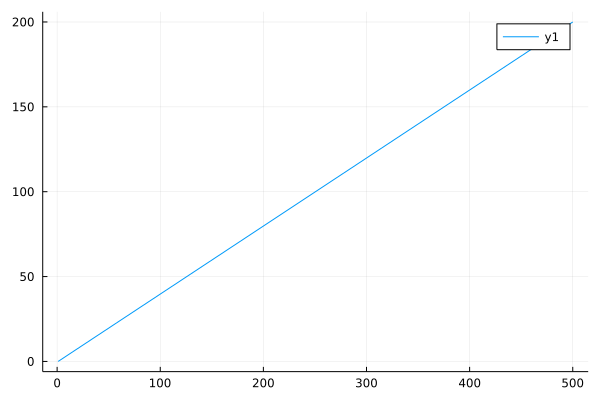

In [7]:
plot(Agrid[:,1])

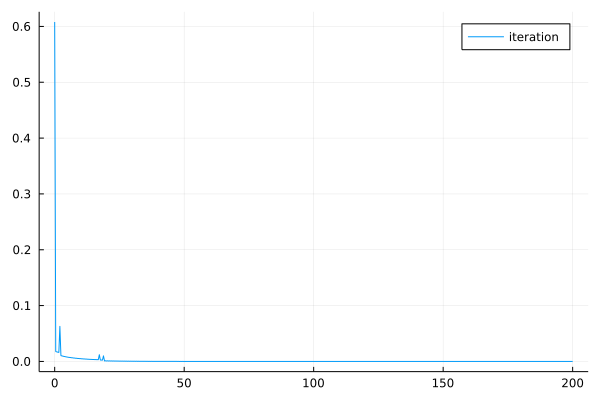

In [8]:
s2 = reshape(s1,(500,7))
s2 = sum(s2, dims=2)
plot(Agrid[:,1], s2, label = "iteration")